# 03 - Privacy Audit (Baseline)

This notebook runs the privacy audit by **importing and calling functions from src modules**:
- `src/train_attacker_conditioned.py` - `extract_features_for_split()`, `train_attacker_epoch()`, `eval_attacker()`
- `src/retrain.py` - `train_epoch()`, `eval_epoch()`, `create_dataloader_exclude()`
- `src/attacker_eval.py` - `matched_negative_evaluation()`, `compute_attack_metrics()`

**Outputs:**
- `outputs/p1.5/s1_matched_negatives.json` - Matched negative indices
- `outputs/p1.5/attacker_v1_seed42.pt` - Trained attacker
- `outputs/p1/retrain_structured/best_model.pt` - Retrain model
- `outputs/p2/retrain_floor.json` - Retrain floor AUC and target band

In [50]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import scanpy as sc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from sklearn.neighbors import NearestNeighbors

from utils import set_global_seed, GLOBAL_SEED, DEVICE, Timer
from vae import VAE, vae_loss
from attacker import MLPAttacker, extract_vae_features, build_attack_features

# Import functions from src/train_attacker_conditioned.py
from train_attacker_conditioned import (
    extract_features_for_split,
    train_attacker_epoch,
    eval_attacker
)

# Import functions from src/retrain.py
from retrain import (
    train_epoch as retrain_train_epoch,
    eval_epoch as retrain_eval_epoch,
    create_dataloader_exclude
)

# Import functions from src/attacker_eval.py
from attacker_eval import (
    matched_negative_evaluation,
    compute_attack_metrics,
    compute_confidence_interval,
    load_matched_negatives
)

set_global_seed(GLOBAL_SEED)

DATA_DIR = Path('../data')
P1_DIR = Path('../outputs/p1')
OUTPUT_DIR = Path('../outputs/p1.5')
P2_DIR = Path('../outputs/p2')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
P2_DIR.mkdir(parents=True, exist_ok=True)

print(f"Global seed: {GLOBAL_SEED}")
print(f"Device: {DEVICE}")

Global seed: 42
Device: cpu


## Load Data, Splits, and Baseline VAE

In [51]:
# Load data
adata = sc.read_h5ad(DATA_DIR / 'adata_processed.h5ad')
print(f"Loaded data: {adata.shape}")

# Load splits
with open(P1_DIR / 'split_structured.json') as f:
    split = json.load(f)

forget_indices = np.array(split['forget_indices'])
retain_indices = np.array(split['retain_indices'])
unseen_indices = np.array(split['unseen_indices'])

print(f"\nSplit sizes:")
print(f"  Forget set: {len(forget_indices)}")
print(f"  Retain set: {len(retain_indices)}")
print(f"  Unseen set: {len(unseen_indices)}")

Loaded data: (33088, 2000)

Split sizes:
  Forget set: 30
  Retain set: 28094
  Unseen set: 4964


In [52]:
# Load baseline VAE
baseline_ckpt = torch.load(P1_DIR / 'baseline' / 'best_model.pt', map_location=DEVICE)
config = baseline_ckpt['config']

baseline_model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    likelihood=config['likelihood'],
    dropout=config.get('dropout', 0.1),
    use_layer_norm=config.get('use_layer_norm', True)
).to(DEVICE)

baseline_model.load_state_dict(baseline_ckpt['model_state_dict'])
baseline_model.eval()

print(f"Loaded baseline VAE from {P1_DIR / 'baseline' / 'best_model.pt'}")
print(f"Architecture: {config['hidden_dims']} -> z={config['latent_dim']}")

Loaded baseline VAE from ../outputs/p1/baseline/best_model.pt
Architecture: [1024, 512, 128] -> z=32


## Create Matched Negative Controls

Find unseen cells that are similar to the forget set in latent space (k-NN matching).

In [53]:
def get_latent_codes(model, adata, indices, device):
    """Extract latent codes z for given indices."""
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    x = torch.FloatTensor(X).to(device)
    
    with torch.no_grad():
        mu, logvar = model.encode(x)
        z = model.reparameterize(mu, logvar)
    return z.cpu().numpy()

# Get latent codes
forget_z = get_latent_codes(baseline_model, adata, forget_indices, DEVICE)
unseen_z = get_latent_codes(baseline_model, adata, unseen_indices, DEVICE)

print(f"Forget latent: {forget_z.shape}")
print(f"Unseen latent: {unseen_z.shape}")

Forget latent: (30, 32)
Unseen latent: (4964, 32)


In [54]:
# Find k-NN matched negatives
K = 10
nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(unseen_z)
distances, indices_knn = nbrs.kneighbors(forget_z)

# Get unique matched indices (global)
matched_local = np.unique(indices_knn.flatten())
matched_indices = [int(unseen_indices[i]) for i in matched_local]

mean_dist = distances.mean()
median_dist = np.median(distances)

print(f"Matched negatives: {len(matched_indices)} cells")
print(f"Mean k-NN distance: {mean_dist:.4f}")
print(f"Median k-NN distance: {median_dist:.4f}")

# Save matched negatives
matched_data = {
    'matched_indices': matched_indices,
    'method': 'latent_knn',
    'k': K,
    'mean_distance': float(mean_dist),
    'median_distance': float(median_dist)
}
with open(OUTPUT_DIR / 's1_matched_negatives.json', 'w') as f:
    json.dump(matched_data, f, indent=2)
print(f"Saved to {OUTPUT_DIR / 's1_matched_negatives.json'}")

Matched negatives: 194 cells
Mean k-NN distance: 5.3539
Median k-NN distance: 5.3705
Saved to ../outputs/p1.5/s1_matched_negatives.json


## Train Attacker

Using imported functions: `extract_features_for_split()`, `train_attacker_epoch()`, `eval_attacker()`

In [55]:
# Extract features using src function
BATCH_SIZE = 256

# Get reference latent codes for kNN features
retain_z = get_latent_codes(baseline_model, adata, retain_indices[:5000], DEVICE)  # Sample for speed

print("Extracting features for forget set...")
forget_feats, forget_knn_r, _ = extract_features_for_split(
    baseline_model, adata, forget_indices, BATCH_SIZE, DEVICE,
    reference_z_retain=retain_z
)

print("Extracting features for matched negatives...")
matched_feats, matched_knn_r, _ = extract_features_for_split(
    baseline_model, adata, np.array(matched_indices), BATCH_SIZE, DEVICE,
    reference_z_retain=retain_z
)

# Build attack features
forget_X = build_attack_features(forget_feats, forget_knn_r, None)
matched_X = build_attack_features(matched_feats, matched_knn_r, None)

feature_dim = forget_X.shape[1]
print(f"\nFeature dimension: {feature_dim}")
print(f"Forget features: {forget_X.shape}")
print(f"Matched features: {matched_X.shape}")

Extracting features for forget set...
Extracting features for matched negatives...

Feature dimension: 70
Forget features: torch.Size([30, 70])
Matched features: torch.Size([194, 70])


In [56]:
# Create training data
member_labels = torch.ones(len(forget_X))
nonmember_labels = torch.zeros(len(matched_X))

all_X = torch.cat([forget_X, matched_X], dim=0)
all_labels = torch.cat([member_labels, nonmember_labels], dim=0)

# Shuffle and split
perm = torch.randperm(len(all_X))
n_train = int(0.8 * len(all_X))

train_X = all_X[perm[:n_train]]
train_y = all_labels[perm[:n_train]]
test_X = all_X[perm[n_train:]]
test_y = all_labels[perm[n_train:]]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f"Train: {len(train_X)}, Test: {len(test_X)}")

Train: 179, Test: 45


In [57]:
# Initialize attacker
attacker = MLPAttacker(
    input_dim=feature_dim,
    hidden_dims=[256, 256],
    dropout=0.3,
    use_spectral_norm=True
).to(DEVICE)

optimizer = optim.Adam(attacker.parameters(), lr=1e-3)

# Train using src function
EPOCHS = 50
print(f"Training attacker for {EPOCHS} epochs...")

with Timer("Attacker training"):
    for epoch in range(EPOCHS):
        # Use train_attacker_epoch from src/train_attacker_conditioned.py
        train_loss = train_attacker_epoch(attacker, train_loader, optimizer, DEVICE)
        
        if (epoch + 1) % 10 == 0:
            # Use eval_attacker from src/train_attacker_conditioned.py
            preds, labels = eval_attacker(attacker, test_loader, DEVICE)
            # Use compute_attack_metrics from src/attacker_eval.py
            metrics = compute_attack_metrics(preds, labels)
            print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} - Test AUC: {metrics['auc']:.4f}")

Training attacker for 50 epochs...
[Attacker training] Starting at 01:54:18
Epoch 10/50 - Loss: 0.7532 - Test AUC: 0.6729
Epoch 20/50 - Loss: 0.3882 - Test AUC: 0.6842
Epoch 30/50 - Loss: 0.3229 - Test AUC: 0.6880
Epoch 40/50 - Loss: 0.3510 - Test AUC: 0.6880
Epoch 50/50 - Loss: 0.3237 - Test AUC: 0.6917
[Attacker training] Completed in 0.37 seconds


In [58]:
# Final evaluation using src/attacker_eval.py function
final_metrics = matched_negative_evaluation(
    attacker, forget_X, matched_X, device=DEVICE
)

print("=== Attacker Training Results (F vs Matched Negatives) ===")
print(f"AUC: {final_metrics['auc']:.4f}")
print(f"95% CI: [{final_metrics['auc_ci_lower']:.4f}, {final_metrics['auc_ci_upper']:.4f}]")
print(f"Accuracy: {final_metrics['accuracy']:.4f}")
print(f"TPR@1%FPR: {final_metrics['tpr_at_fpr_01']:.4f}")
print(f"TPR@5%FPR: {final_metrics['tpr_at_fpr_05']:.4f}")

=== Attacker Training Results (F vs Matched Negatives) ===
AUC: 0.7735
95% CI: [0.6679, 0.8698]
Accuracy: 0.8661
TPR@1%FPR: 0.0000
TPR@5%FPR: 0.3667


In [59]:
# Save attacker
attacker_ckpt = {
    'model_state_dict': attacker.state_dict(),
    'config': {
        'input_dim': feature_dim,
        'hidden_dims': [256, 256],
        'dropout': 0.3,
        'use_spectral_norm': True
    },
    'final_auc': final_metrics['auc'],
    'metrics': final_metrics
}
torch.save(attacker_ckpt, OUTPUT_DIR / 'attacker_v1_seed42.pt')
print(f"Saved attacker to {OUTPUT_DIR / 'attacker_v1_seed42.pt'}")

Saved attacker to ../outputs/p1.5/attacker_v1_seed42.pt


## Train Retrain Model

Using imported functions: `train_epoch()`, `eval_epoch()`, `create_dataloader_exclude()`

In [60]:
# Create data loaders for retraining (excluding forget set)
# Using create_dataloader_exclude from src/retrain.py
retrain_output_dir = P1_DIR / 'retrain_structured'
retrain_output_dir.mkdir(parents=True, exist_ok=True)

# Split retain into train/val (85/15)
np.random.seed(GLOBAL_SEED)
retain_shuffled = retain_indices.copy()
np.random.shuffle(retain_shuffled)
n_train = int(0.85 * len(retain_shuffled))

train_indices_retrain = retain_shuffled[:n_train]
val_indices_retrain = retain_shuffled[n_train:]

# Use create_dataloader_exclude from src/retrain.py
train_loader_retrain = create_dataloader_exclude(
    adata, train_indices_retrain, [], batch_size=BATCH_SIZE, shuffle=True
)
val_loader_retrain = create_dataloader_exclude(
    adata, val_indices_retrain, [], batch_size=BATCH_SIZE, shuffle=False
)

print(f"Retrain data (D\\F):")
print(f"  Train: {len(train_indices_retrain)}")
print(f"  Val: {len(val_indices_retrain)}")

Retrain data (D\F):
  Train: 23879
  Val: 4215


In [61]:
# Initialize retrain model (fresh, same architecture)
set_global_seed(GLOBAL_SEED)

retrain_model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    likelihood=config['likelihood'],
    dropout=config.get('dropout', 0.1),
    use_layer_norm=config.get('use_layer_norm', True)
).to(DEVICE)

optimizer_retrain = optim.Adam(retrain_model.parameters(), lr=config.get('lr', 1e-4))

print(f"Initialized retrain VAE: {sum(p.numel() for p in retrain_model.parameters())} parameters")

Initialized retrain VAE: 7349984 parameters


In [62]:
# Train retrain model using src/retrain.py functions
RETRAIN_EPOCHS = 100
best_val_loss = float('inf')
history = {'train': [], 'val': []}

print(f"Training retrain model for {RETRAIN_EPOCHS} epochs...")

with Timer("Retrain"):
    for epoch in range(RETRAIN_EPOCHS):
        # Use train_epoch from src/retrain.py
        train_metrics = retrain_train_epoch(
            retrain_model, train_loader_retrain, optimizer_retrain, 
            DEVICE, config['likelihood'], beta=1.0
        )
        # Use eval_epoch from src/retrain.py
        val_metrics = retrain_eval_epoch(
            retrain_model, val_loader_retrain, 
            DEVICE, config['likelihood'], beta=1.0
        )
        
        history['train'].append(train_metrics)
        history['val'].append(val_metrics)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{RETRAIN_EPOCHS} - "
                  f"Train Loss: {train_metrics['loss']:.4f} - "
                  f"Val Loss: {val_metrics['loss']:.4f}")
        
        if val_metrics['loss'] < best_val_loss:
            best_val_loss = val_metrics['loss']
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': retrain_model.state_dict(),
                'optimizer_state_dict': optimizer_retrain.state_dict(),
                'val_loss': val_metrics['loss'],
                'config': config,
                'forget_set_size': len(forget_indices)
            }
            torch.save(checkpoint, retrain_output_dir / 'best_model.pt')

print(f"\nBest val loss: {best_val_loss:.4f}")
print(f"Saved to {retrain_output_dir / 'best_model.pt'}")

Training retrain model for 100 epochs...
[Retrain] Starting at 01:54:20


Epoch 10/100 - Train Loss: 394.1559 - Val Loss: 383.3510
Epoch 20/100 - Train Loss: 383.6381 - Val Loss: 375.3017
Epoch 30/100 - Train Loss: 379.1231 - Val Loss: 371.7483
Epoch 40/100 - Train Loss: 376.0653 - Val Loss: 369.5075
Epoch 50/100 - Train Loss: 374.0008 - Val Loss: 367.3918
Epoch 60/100 - Train Loss: 371.8435 - Val Loss: 365.6495
Epoch 70/100 - Train Loss: 370.4955 - Val Loss: 364.6352
Epoch 80/100 - Train Loss: 369.4228 - Val Loss: 363.9237
Epoch 90/100 - Train Loss: 368.4820 - Val Loss: 363.3206
Epoch 100/100 - Train Loss: 367.6737 - Val Loss: 362.9178
[Retrain] Completed in 607.37 seconds

Best val loss: 362.8927
Saved to ../outputs/p1/retrain_structured/best_model.pt


## Evaluate Retrain Floor

In [63]:
# Load best retrain model
retrain_ckpt = torch.load(retrain_output_dir / 'best_model.pt', map_location=DEVICE)
retrain_model.load_state_dict(retrain_ckpt['model_state_dict'])
retrain_model.eval()

print(f"Loaded retrain model (epoch {retrain_ckpt['epoch']}, val_loss={retrain_ckpt['val_loss']:.4f})")

Loaded retrain model (epoch 97, val_loss=362.8927)


In [64]:
# Extract features from RETRAIN model consistently with how attacker was trained
# Must include kNN distances to match the 70-dim features

# Get retain latent codes for kNN (from retrain model)
retrain_retain_z = get_latent_codes(retrain_model, adata, retain_indices[:5000], DEVICE)

# Extract features using same method as cell 9
print("Extracting features for forget set (retrain model)...")
retrain_forget_feats_dict, retrain_forget_knn, _ = extract_features_for_split(
    retrain_model, adata, forget_indices, BATCH_SIZE, DEVICE,
    reference_z_retain=retrain_retain_z
)
retrain_forget_feats = build_attack_features(retrain_forget_feats_dict, retrain_forget_knn, None)

print("Extracting features for matched negatives (retrain model)...")
retrain_matched_feats_dict, retrain_matched_knn, _ = extract_features_for_split(
    retrain_model, adata, np.array(matched_indices), BATCH_SIZE, DEVICE,
    reference_z_retain=retrain_retain_z
)
retrain_matched_feats = build_attack_features(retrain_matched_feats_dict, retrain_matched_knn, None)

print(f"Retrain forget features: {retrain_forget_feats.shape}")
print(f"Retrain matched features: {retrain_matched_feats.shape}")

Extracting features for forget set (retrain model)...
Extracting features for matched negatives (retrain model)...
Retrain forget features: torch.Size([30, 70])
Retrain matched features: torch.Size([194, 70])


In [65]:
# Evaluate retrain floor using matched_negative_evaluation from src/attacker_eval.py
retrain_metrics = matched_negative_evaluation(
    attacker, retrain_forget_feats, retrain_matched_feats, device=DEVICE
)

print("=== Retrain Floor (F vs Matched on Retrain Model) ===")
print(f"AUC: {retrain_metrics['auc']:.4f}")
print(f"95% CI: [{retrain_metrics['auc_ci_lower']:.4f}, {retrain_metrics['auc_ci_upper']:.4f}]")
print(f"Accuracy: {retrain_metrics['accuracy']:.4f}")
print(f"TPR@1%FPR: {retrain_metrics['tpr_at_fpr_01']:.4f}")
print(f"TPR@5%FPR: {retrain_metrics['tpr_at_fpr_05']:.4f}")

=== Retrain Floor (F vs Matched on Retrain Model) ===
AUC: 0.4814
95% CI: [0.3758, 0.5869]
Accuracy: 0.8661
TPR@1%FPR: 0.0000
TPR@5%FPR: 0.0333


In [66]:
# Extract features from BASELINE model consistently with how attacker was trained
# Must include kNN distances to match the 70-dim features

# Get retain latent codes for kNN (from baseline model)
baseline_retain_z = get_latent_codes(baseline_model, adata, retain_indices[:5000], DEVICE)

# Extract features using same method as cell 9
print("Extracting features for forget set (baseline model)...")
baseline_forget_feats_dict, baseline_forget_knn, _ = extract_features_for_split(
    baseline_model, adata, forget_indices, BATCH_SIZE, DEVICE,
    reference_z_retain=baseline_retain_z
)
baseline_forget_feats = build_attack_features(baseline_forget_feats_dict, baseline_forget_knn, None)

print("Extracting features for matched negatives (baseline model)...")
baseline_matched_feats_dict, baseline_matched_knn, _ = extract_features_for_split(
    baseline_model, adata, np.array(matched_indices), BATCH_SIZE, DEVICE,
    reference_z_retain=baseline_retain_z
)
baseline_matched_feats = build_attack_features(baseline_matched_feats_dict, baseline_matched_knn, None)

baseline_metrics = matched_negative_evaluation(
    attacker, baseline_forget_feats, baseline_matched_feats, device=DEVICE
)

print("=== Baseline (F vs Matched on Baseline Model) ===")
print(f"AUC: {baseline_metrics['auc']:.4f}")
print(f"95% CI: [{baseline_metrics['auc_ci_lower']:.4f}, {baseline_metrics['auc_ci_upper']:.4f}]")

Extracting features for forget set (baseline model)...
Extracting features for matched negatives (baseline model)...
=== Baseline (F vs Matched on Baseline Model) ===
AUC: 0.7694
95% CI: [0.6669, 0.8646]


In [67]:
# Define target band (retrain floor ± 0.03)
retrain_floor = retrain_metrics['auc']
target_band = [retrain_floor - 0.03, retrain_floor + 0.03]

print(f"\n{'='*50}")
print(f"SUMMARY")
print(f"{'='*50}")
print(f"\nBaseline AUC: {baseline_metrics['auc']:.4f}")
print(f"Retrain floor: {retrain_floor:.4f}")
print(f"Target band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")
print(f"\nSuccessful unlearning = AUC within target band")

# Save retrain floor
retrain_floor_data = {
    'auc_floor': float(retrain_floor),
    'target_band': [float(x) for x in target_band],
    'baseline_auc': float(baseline_metrics['auc']),
    'retrain_metrics': {k: float(v) if isinstance(v, (int, float, np.floating)) else v 
                        for k, v in retrain_metrics.items()},
    'baseline_metrics': {k: float(v) if isinstance(v, (int, float, np.floating)) else v 
                         for k, v in baseline_metrics.items()}
}
with open(P2_DIR / 'retrain_floor.json', 'w') as f:
    json.dump(retrain_floor_data, f, indent=2)
print(f"\nSaved to {P2_DIR / 'retrain_floor.json'}")


SUMMARY

Baseline AUC: 0.7694
Retrain floor: 0.4814
Target band: [0.4514, 0.5114]

Successful unlearning = AUC within target band

Saved to ../outputs/p2/retrain_floor.json


## Visualization

In [68]:
from sklearn.metrics import roc_curve

# Get predictions for ROC curves
attacker.eval()
with torch.no_grad():
    baseline_forget_probs = torch.sigmoid(attacker(baseline_forget_feats.to(DEVICE))).cpu().numpy().flatten()
    baseline_matched_probs = torch.sigmoid(attacker(baseline_matched_feats.to(DEVICE))).cpu().numpy().flatten()
    retrain_forget_probs = torch.sigmoid(attacker(retrain_forget_feats.to(DEVICE))).cpu().numpy().flatten()
    retrain_matched_probs = torch.sigmoid(attacker(retrain_matched_feats.to(DEVICE))).cpu().numpy().flatten()

# Compute ROC curves
baseline_y = np.concatenate([np.ones(len(baseline_forget_probs)), np.zeros(len(baseline_matched_probs))])
baseline_scores = np.concatenate([baseline_forget_probs, baseline_matched_probs])
baseline_fpr, baseline_tpr, _ = roc_curve(baseline_y, baseline_scores)

retrain_y = np.concatenate([np.ones(len(retrain_forget_probs)), np.zeros(len(retrain_matched_probs))])
retrain_scores = np.concatenate([retrain_forget_probs, retrain_matched_probs])
retrain_fpr, retrain_tpr, _ = roc_curve(retrain_y, retrain_scores)

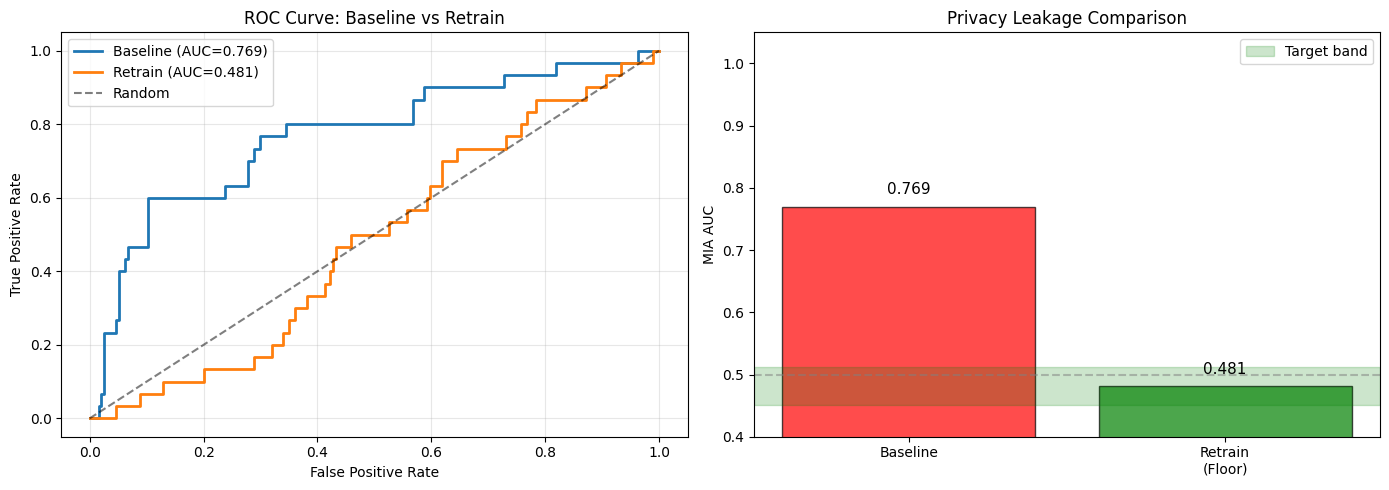

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
axes[0].plot(baseline_fpr, baseline_tpr, 
             label=f"Baseline (AUC={baseline_metrics['auc']:.3f})", linewidth=2)
axes[0].plot(retrain_fpr, retrain_tpr, 
             label=f"Retrain (AUC={retrain_metrics['auc']:.3f})", linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve: Baseline vs Retrain')
axes[0].legend()
axes[0].grid(alpha=0.3)

# AUC comparison
methods = ['Baseline', 'Retrain\n(Floor)']
aucs = [baseline_metrics['auc'], retrain_metrics['auc']]
colors = ['red', 'green']
bars = axes[1].bar(methods, aucs, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1].set_ylabel('MIA AUC')
axes[1].set_title('Privacy Leakage Comparison')
axes[1].set_ylim([0.4, 1.05])
axes[1].legend()

for bar, auc in zip(bars, aucs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{auc:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'privacy_baseline_vs_retrain.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

### Outputs Created
| Output | Path |
|--------|------|
| Matched negatives | `outputs/p1.5/s1_matched_negatives.json` |
| Attacker checkpoint | `outputs/p1.5/attacker_v1_seed42.pt` |
| Retrain model | `outputs/p1/retrain_structured/best_model.pt` |
| Retrain floor | `outputs/p2/retrain_floor.json` |

### Key Numbers
| Metric | Baseline | Retrain Floor |
|--------|----------|---------------|
| AUC | See above | See above |
| Target band | - | floor ± 0.03 |

### src Functions Used
- `train_attacker_conditioned.extract_features_for_split()` - Feature extraction
- `train_attacker_conditioned.train_attacker_epoch()` - Attacker training
- `train_attacker_conditioned.eval_attacker()` - Attacker evaluation
- `retrain.train_epoch()` - VAE training
- `retrain.eval_epoch()` - VAE evaluation
- `retrain.create_dataloader_exclude()` - DataLoader creation
- `attacker_eval.matched_negative_evaluation()` - MIA evaluation
- `attacker_eval.compute_attack_metrics()` - Metric computation

## Next Steps

- **04_adversarial_unlearning.ipynb**: Attempt adversarial unlearning
- **05_fisher_unlearning.ipynb**: Fisher-based unlearning